We want to understand whether company XYZ should sell the product at the higher(\$59) or lower price(\$39). The first question, we will try to answer is whether there is a significant effect of the price on conversion. This will also help us understand what factors increase conversion rate. While doing this we will also dig into how this can translate into revenues.

In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
import os 
os.chdir('/Users/syedrahman/Documents/Summer2017/Insight/ABtesting')
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns
import datetime as dt
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
import holidays
us_holidays = holidays.UnitedStates() 
import statsmodels.discrete.discrete_model as sm
from scipy.stats import norm

In [76]:
test_data = pd.read_csv('test_results.csv')

In [77]:
user_data = pd.read_csv('user_table.csv')

In [78]:
test_data.shape

(316800, 8)

In [79]:
user_data.shape

(275616, 5)

Had trouble getting the model to run, so I left out user information for the time being.

In [80]:
#data = test_data.merge(user_data, how = 'left', on = 'user_id')
data = test_data

First we check for any null values

In [81]:
data.shape

(316800, 8)

In [82]:
pd.isnull(data).apply(sum, axis = 0)

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [83]:
pd.isnull(test_data).apply(sum, axis = 0)

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

Looks like a lot of the users_id's in the test set is not in the user_data. We will try several different approaches here. The first is to discard the rows where we don't have location information. If location proves to be useful, we can stop there. Or we can impute data based on the other data points. Finally, if location doesn't prove important, we can just focus on the test_data. Let's look at some plots first to see if the data is encoded properly. 

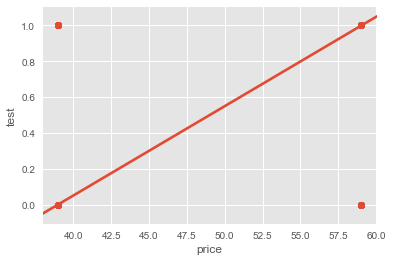

In [84]:
ax = sns.regplot(x="price", y="test", data=data)

Seems like some point in the test have prices of 39, while some points in control have prices of 59. We have to discard these mislabeled points.

In [85]:
cleaned_data = data[(data['test']==1) & (data['price']==59) | (data['test']==0) & (data['price']==39)]

In [86]:
cleaned_data_dropna = cleaned_data.dropna(axis=0)

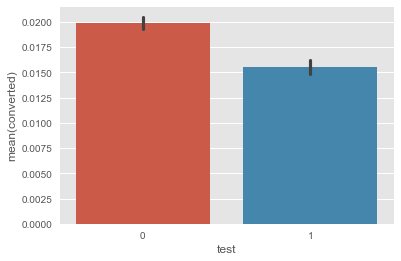

In [87]:
sns.barplot(x = 'test', y= 'converted', data = cleaned_data_dropna)

Seems like the conversion is higher in the control group, so the increased price led to lower conversions. Seems to make sense. But we need to make sure, this was significant. In addition, these are only marginal effects. We will dig further into this later. 

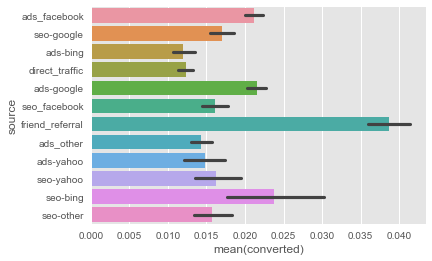

In [88]:
sns.barplot(x = 'converted', y= 'source', data = cleaned_data_dropna)

It's quite clear that friends referrals seems to have the largest effects on converted.

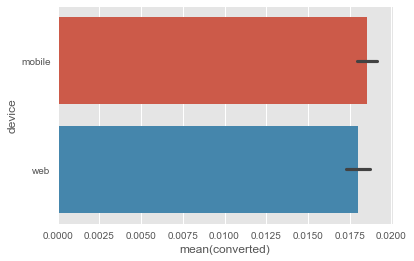

In [89]:
sns.barplot(x = 'converted', y= 'device', data = cleaned_data_dropna)

Not much difference in terms of device, but we should remember that these are marginal effects.

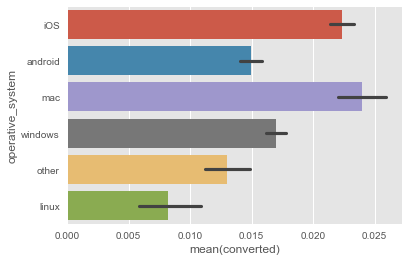

In [90]:
sns.barplot(x = 'converted', y= 'operative_system', data = cleaned_data_dropna)

Also seems like MACs are most likely to convert, while linux's are least likely.

In [91]:
#sns.barplot(x = 'converted', y= 'city', data = cleaned_data_dropna)

There are too many cities to really see which ones make a difference from the plots, but it's clear that marginally it does seem to make a difference. Would be interesting to see what happens when we control for other factors. Now we separate time by hour and days by week.

In [92]:
date_object = []
day_object = []
hour_object = []
holidays_object = []
for x in cleaned_data_dropna['timestamp']:
    try: 
        date_object.append(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
        hour_object.append(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)
        day_object.append(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday())
        holidays_object.append(1.0*(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date() in us_holidays))
    except ValueError:
        date_object.append('NaN')
        hour_object.append('NaN')
        day_object.append('NaN')
        holidays_object.append('Nan')

In [93]:
cleaned_data_dropna['Date'] = pd.to_datetime(pd.Series(date_object)).values
cleaned_data_dropna['Day'] = pd.Series(day_object).values
cleaned_data_dropna['Hour'] = pd.Series(hour_object).values
cleaned_data_dropna['Holidays'] = pd.Series(holidays_object).values

In [94]:
cleaned_data_dropna = cleaned_data_dropna.dropna(axis = 0)

In [95]:
print(sum(cleaned_data_dropna['test']==1))
print(sum(cleaned_data_dropna['test']==0))

110306
195869


In [96]:
def getXy(cleaned_data_dropna):
    X = pd.get_dummies(cleaned_data_dropna['Day'], prefix='Day', prefix_sep='_', drop_first=True)
    X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['Hour'], prefix='Hour', prefix_sep='_', drop_first=True)], axis = 1)
    X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['source'], prefix='source', prefix_sep='_',drop_first=True)], axis = 1)
    X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['device'], prefix='device', prefix_sep='_',drop_first=True)], axis = 1)
    X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['operative_system'], prefix='operative_system', prefix_sep='_',drop_first=True)], axis = 1)
    X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['operative_system'], prefix='operative_system', prefix_sep='_',drop_first=True)], axis = 1)
    X = pd.concat([X,cleaned_data_dropna['test']], axis = 1)
    #X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['city'], prefix='city', prefix_sep='_',drop_first=True)], axis = 1)
    X = pd.concat([X,cleaned_data_dropna['Holidays']], axis = 1)  
    y = cleaned_data_dropna['converted']
    return (X,y)

In [97]:
Xy = getXy(cleaned_data_dropna)
X = Xy[0]
y = Xy[1]

We will check two types of independent variable. The first is through revenue, which is basically, the price\*conversion while the second is conversion. Since we mostly care about interpretability, we will stick t simple models like the linear regression and logistic regression.  

In [98]:
np.random.seed(1)
indx = np.random.choice(y[y==0].index,size = sum(y!=0))
indx2 = y[y!=0].index
print(indx)
print(indx2) 

[134883 281761  77360 ...,  74010   9739 114239]
Int64Index([     7,     13,     46,     78,    107,    295,    355,    403,
               420,    457,
            ...
            316155, 316280, 316349, 316404, 316449, 316474, 316504, 316561,
            316657, 316753],
           dtype='int64', length=5615)


In [99]:
y_red = pd.concat([y.loc[indx],y.loc[indx2]])
X_red = pd.concat([X.loc[indx],X.loc[indx2]])

In [100]:
logit = sm.Logit(y_red, X_red.astype(float))
result = logit.fit()

         Current function value: 0.670062
         Iterations: 35


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [101]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                11230
Model:                          Logit   Df Residuals:                    11182
Method:                           MLE   Df Model:                           47
Date:                Tue, 11 Jul 2017   Pseudo R-squ.:                 0.03330
Time:                        00:48:12   Log-Likelihood:                -7524.8
converged:                      False   LL-Null:                       -7784.0
                                        LLR p-value:                 1.072e-80
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Day_1                       -0.1496      0.110     -1.364      0.172      -0.365       0.065
Day_2                       -0.0357      0.110     -0.325      0.745      -0.251       0.

Controlling for all variables, it seems as if test has a negative effect. Hence, conversion goes down if we get the higher price, which was expected. Amongst the other factors that were psotive and statsitically significant were source_seo-google, source_ads_facebook, source_friend_referral, source_seo-bing compared to bing ads, which was the base case scenario. Also some of the times are significant and these seem to have a negative effect compared to the base case which is around between midnight and 1:00 am. Hence we should not increase the prices as that leads to lower conversions. One thing we should check is whether this may actually lead to lower revenues. Suppose we have a fixed number of possible converions. Then it makes sense to go with the higher price if 59\*p_1 > 39\*p_2, where p_1 is the probablity of being in the test group and p_2 is the probability of being in the control group. Hence if p_1/p_2 > 0.39/0.59, we should go with the higher price. 

In [102]:
y_pred = pd.DataFrame(result.predict(X_red.astype(float)))

Note that for \$59 option to be worthwhile, we would need 59*p_1 > 39*p_2, where p_1 is the proportion of people converting in the test group while p_2 is the proportion of people converting in the control group. It's difficult to get good estimates for these using the model we have uses thus far. What we can consider in this case is dividing up the experiment into different factions and looking at these individually. We will only consider the scenario where the source is seo-google. Since time was the oher significant factor, we should also consider those, but for now I'll ignore that. Going back to the problem now, we need p_1/p_2 > 0.39/0.59 = 0.661. What I'll do is build a confidence interval for the risk ratio to check if this is indeed true. Otherwise, it makes sense to just stick to the original price of \$39.

In [103]:
def rrCI(x1,x2,n1,n2, alpha):
    z = norm.ppf(1-alpha/2)
    p1 = x1*1.0/n1
    p2 = x2*1.0/n2
    rr = p1/p2
    se = np.sqrt((n1-x1)/(x1*n1) + (n2-x2)/(x2*n2))
    lb = np.exp(np.log(rr) - z*se)
    ub = np.exp(np.log(rr) + z*se)
    return (lb,ub)

In [104]:
def rrBySource(source):
    cleaned_data_dropna_seo_google = cleaned_data_dropna[cleaned_data_dropna['source']==source]
    x1 = sum(cleaned_data_dropna_seo_google[cleaned_data_dropna_seo_google['test']==1]['converted']==1)
    n1 = len(cleaned_data_dropna_seo_google[cleaned_data_dropna_seo_google['test']==1])
    x2 = sum(cleaned_data_dropna_seo_google[cleaned_data_dropna_seo_google['test']==0]['converted']==1)
    n2 = len(cleaned_data_dropna_seo_google[cleaned_data_dropna_seo_google['test']==0])
    return rrCI(x1,x2,n1,n2,0.05)

In [105]:
for x in cleaned_data_dropna['source'].unique():
    print(x,rrBySource(x))
    print('---------------')

ads_facebook (0.62007929938054929, 0.80385240138704961)
---------------
seo-google (0.72865674991379048, 1.1130292819834153)
---------------
ads-bing (0.58089333342541516, 0.98055399716351155)
---------------
direct_traffic (0.64912285446554996, 0.89242610415642909)
---------------
ads-google (0.76836467724086432, 0.9721940292743767)
---------------
seo_facebook (0.6247512569410798, 0.99150698935832116)
---------------
friend_referral (0.69457442573481254, 0.93466478688659405)
---------------
ads_other (0.63318370797377577, 0.96338745611808563)
---------------
ads-yahoo (0.40823311959342246, 0.96451046272834207)
---------------
seo-yahoo (0.34221784698585089, 0.83329481930016691)
---------------
seo-bing (0.2393119402968219, 0.90516510686515439)
---------------
seo-other (0.50415073524483622, 1.0290428361963566)
---------------


Focusing on just the source, we can see that we have the desired range to switch to the increased price on seo-google, ads-google and friend_referral. For the other categories, it really doesn't make sense to switch.